### installing the required libraries

In [162]:
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install scikit-learn

!pip install flask-ngrok
!pip install folium
!pip install pyngrok==4.1.1
!pip install geopy
!pip install pgeocode
!ngrok authtoken enter your authentication token here

Authtoken saved to configuration file: C:\Users\EndUser/.ngrok2/ngrok.yml


### importing the basic libraries

In [163]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from flask import Flask, render_template, request, send_from_directory
import folium
from flask_ngrok import run_with_ngrok
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import requests
import geopy
from geopy.geocoders import Nominatim
import pgeocode
nomi = pgeocode.Nominatim('us')

%matplotlib inline

### loading the realestate_prices dataset

In [164]:
df = pd.read_csv('realestate_prices.csv')

In [165]:
df.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,2000-01-31,...,2022-12-31,2023-01-31,2023-02-28,2023-03-31,2023-04-30,2023-05-31,2023-06-30,2023-07-31,2023-08-31,2023-09-30
0,91982,1,77494,zip,TX,TX,Katy,"Houston-The Woodlands-Sugar Land, TX",Fort Bend County,210998.274855,...,477993.980265,475781.230089,474477.961277,473439.827111,474653.524348,476661.984057,479794.936271,482597.324009,485083.056594,486910.114726
1,61148,2,8701,zip,NJ,NJ,Lakewood,"New York-Newark-Jersey City, NY-NJ-PA",Ocean County,138236.106220,...,526688.496534,529065.655134,531291.205373,534197.368329,538377.145099,543770.909659,549747.786643,555895.280469,561828.200137,568194.498423
2,91940,3,77449,zip,TX,TX,Katy,"Houston-The Woodlands-Sugar Land, TX",Harris County,103318.630160,...,283864.948365,281434.776942,279092.679058,277234.960535,276040.337909,275560.590268,275939.451372,276700.188180,277596.655001,278130.312100
3,62080,4,11368,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,149035.558030,...,503622.567716,498054.569558,491140.641900,484774.625546,478103.650835,470951.343102,465519.157578,463684.283059,463678.295654,463117.230849
4,91733,5,77084,zip,TX,TX,Houston,"Houston-The Woodlands-Sugar Land, TX",Harris County,101939.033374,...,274632.995125,273073.699280,271477.156735,270153.639535,269362.402315,269219.891252,269817.371906,270660.259532,271532.872461,271960.685440


### shape of the dataframe

In [166]:
df.shape

(26368, 294)

### checking for missing values

In [167]:
print(df.isna().sum())

RegionID        0
SizeRank        0
RegionName      0
RegionType      0
StateName       0
             ... 
2023-05-31    469
2023-06-30    468
2023-07-31    467
2023-08-31    467
2023-09-30      0
Length: 294, dtype: int64


### dropping all the records with missing values

In [168]:
df.dropna(inplace=True)

### checking shape of dataframe after dropping records with missing values

In [169]:
df.shape

(10611, 294)

### drop unnecessary columns

In [170]:
new_df = df.drop(['RegionID', 'SizeRank', 'RegionType', 'StateName','Metro'],axis=1)

# renaming the column RegionName to zipcode
new_df.rename(columns={'RegionName': 'zipcode'}, inplace=True)

### melting the dataframe keeping columns as 'zipcode','CountyName','City','State', 'Date', 'Price'

In [171]:
new_df_melt = new_df.melt(id_vars=['zipcode','CountyName','City','State'], var_name='Date', value_name='Price')

In [172]:
new_df_melt.head()

,zipcode,CountyName,City,State,Date,Price
0,77494,Fort Bend County,Katy,TX,2000-01-31,210998.274855
1,8701,Ocean County,Lakewood,NJ,2000-01-31,138236.106220
2,77449,Harris County,Katy,TX,2000-01-31,103318.630160
3,11368,Queens County,New York,NY,2000-01-31,149035.558030
4,77084,Harris County,Houston,TX,2000-01-31,101939.033374


### Sort dataset by 'zipcode','CountyName','City','State','Date'

In [173]:
new_df_melt_sorted = new_df_melt.sort_values(by=['zipcode','CountyName','City','State','Date']).reset_index(drop=True)

### datatype conversion

In [174]:
new_df_melt_sorted['Date'] = pd.to_datetime(new_df_melt_sorted['Date']) # converting data type of 'Date' from string to datetime
new_df_melt_sorted['zipcode'] = new_df_melt_sorted['zipcode'].astype('str') # converting data type of zipcode from int to string

### extract new features from 'Date'

In [175]:
new_df_melt_sorted['Year'] = new_df_melt_sorted['Date'].dt.year # extracting 'Year'
new_df_melt_sorted['Month'] = new_df_melt_sorted['Date'].dt.month # extracting 'Month'

# droping the original 'Date' column after extracting 'Year' and 'Month'
new_df_melt_sorted.drop('Date', axis=1, inplace=True)

In [176]:
new_df_melt_sorted.dtypes

zipcode        object
CountyName     object
City           object
State          object
Price         float64
Year            int64
Month           int64
dtype: object

## replacing price

In [177]:
# replacing the Price with the mean of each month's price for every year for every zipcode
new_df_melt_sorted = new_df_melt_sorted.groupby(['zipcode', 'CountyName', 'City', 'State', 'Year'])['Price'].mean().reset_index()
# converting data type of Price from float to int
new_df_melt_sorted['Price'] = new_df_melt_sorted['Price'].astype('int')

In [178]:
new_df_melt_sorted.dtypes

zipcode       object
CountyName    object
City          object
State         object
Year           int64
Price          int32
dtype: object

# EDA

In [179]:
print(new_df_melt_sorted.head(12))

   zipcode       CountyName      City State  Year    Price
0    10001  New York County  New York    NY  2000   790812
1    10001  New York County  New York    NY  2001   912253
2    10001  New York County  New York    NY  2002  1050018
3    10001  New York County  New York    NY  2003  1166322
4    10001  New York County  New York    NY  2004  1259462
5    10001  New York County  New York    NY  2005  1559704
6    10001  New York County  New York    NY  2006  1786005
7    10001  New York County  New York    NY  2007  1793676
8    10001  New York County  New York    NY  2008  1863590
9    10001  New York County  New York    NY  2009  1638641
10   10001  New York County  New York    NY  2010  1523628
11   10001  New York County  New York    NY  2011  1592870


In [180]:
new_df_melt_sorted.dtypes

zipcode       object
CountyName    object
City          object
State         object
Year           int64
Price          int32
dtype: object

In [181]:
# Group by State and calculate average price
state_price_avg = new_df_melt_sorted.groupby('State')['Price'].mean().sort_values()

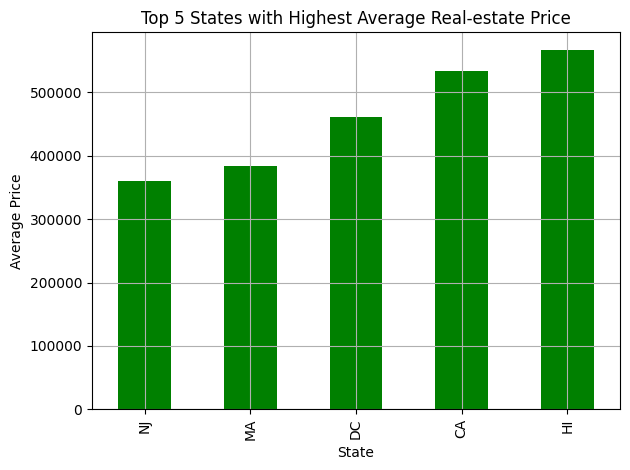

In [182]:
# Top 5 states with the highest average value of Price
top_5_highest_avg_price = state_price_avg.tail(5)
top_5_highest_avg_price.plot(kind='bar', color='green')
plt.title('Top 5 States with Highest Average Real-estate Price')
plt.ylabel('Average Price')
plt.xlabel('State')
plt.grid()
plt.tight_layout()
plt.show()

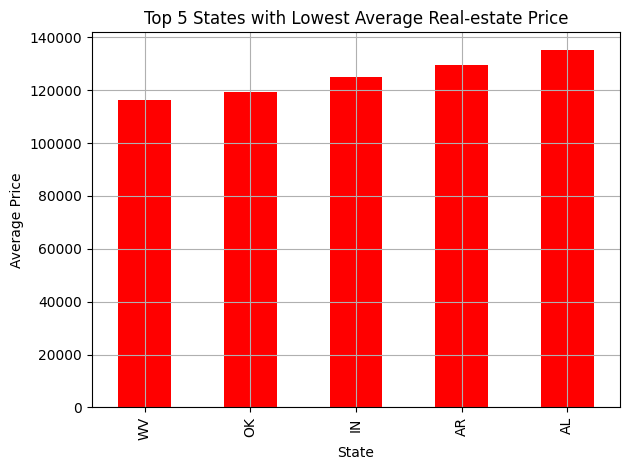

In [183]:
# Top 5 states with the least average value of Price
top_5_lowest_avg_price = state_price_avg.head(5)
top_5_lowest_avg_price.plot(kind='bar', color='red')
plt.title('Top 5 States with Lowest Average Real-estate Price')
plt.ylabel('Average Price')
plt.xlabel('State')
plt.grid()
plt.tight_layout()
plt.show()

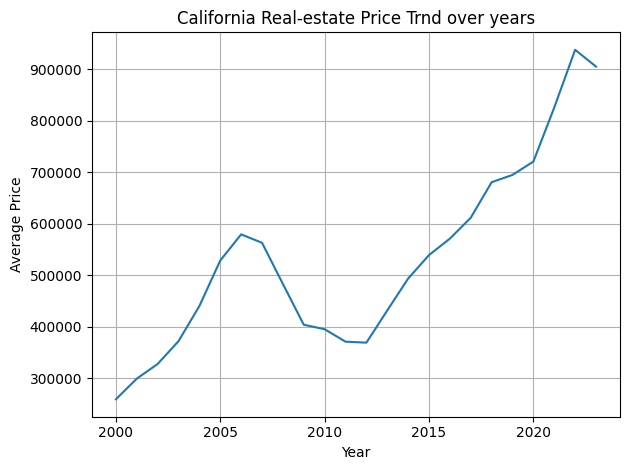

In [184]:
new_df_melt_sorted[new_df_melt_sorted['State']=='CA'].groupby('Year')['Price'].mean().plot()
plt.title('California Real-estate Price Trnd over years')
plt.ylabel('Average Price')
plt.xlabel('Year')
plt.grid()
plt.tight_layout()
plt.show()

# Linear Regression

In [199]:
X = new_df_melt_sorted[['zipcode', 'CountyName', 'City', 'State', 'Year']] # independent features
y = new_df_melt_sorted['Price'] # dependent feature

# splitting data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33) # taking the test size as 33.33%

# preprocessing categorical columns and numerical column
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), ['zipcode', 'CountyName', 'City', 'State']),
        ('num', StandardScaler(), ['Year'])
    ])

# pipeline with preprocessing and model(linear regression)
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression()) # using linear regression
])

# training
pipeline.fit(X_train, y_train)

# testing
y_pred = pipeline.predict(X_test)

# evaluation
r2 = round(r2_score(y_test, y_pred),2)
print(f'R-squared: {r2}')

R-squared: 0.85


## predict_price

In [186]:
def predict_price(zipcode, year):
    # Take user input for zipcode, CountyName, City, State, Year, and Month
    ''' 
    This method takes the user entered zipcode and gets the details like city, county name, state for 
    the entered zipcode and uses that data along with the user entered zipcode and year to predict the 
    price.
    '''
    zipcode = zipcode
    year = int(year)
    zip_code_details = (new_df_melt_sorted.loc[new_df_melt_sorted['zipcode'] == zipcode])
    first_row = zip_code_details.iloc[0]

    # extracting City, CountyName, and State
    city = first_row['City']
    county_name = first_row['CountyName']
    state = first_row['State']

    # creating a DataFrame with user input
    user_input = pd.DataFrame({
        'zipcode': [zipcode],
        'CountyName': [county_name],
        'City': [city],
        'State': [state],
        'Year': [year]
    })

    user_input_encoded = pipeline.named_steps['preprocessor'].transform(user_input)
    predicted_price = pipeline.named_steps['model'].predict(user_input_encoded)

    return int(predicted_price[0])


# Predict using the predict function
# predicted_price = predict_price('1001',2004)
# print(f"Predicted price: {int(predicted_price)}")

Predicted price: 128700


## Analysis on Zipcodes of States

In [187]:
def map_expensive_zipcodes(data, year):
    '''
    Generates a folium map with markers indicating the top and bottom expensive zip codes
    for each state in the USA for a given year. Markers are color-coded: red for most expensive,
    blue for least expensive.

    Parameters:
    data (DataFrame): The dataset containing real estate price information.
    year (int): The specific year for which the map is generated.
    '''
    year_data = data[data['Year'] == year]
    zipcode_prices = year_data.groupby(['State', 'zipcode'])['Price'].mean().reset_index()
    geolocator = pgeocode.Nominatim('us')

    # Function to retrieve latitude and longitude from a zip code
    def get_zip_info(zip_code):
        formatted_zip = str(zip_code).zfill(5)
        location = geolocator.query_postal_code(formatted_zip)
        if location is None or pd.isnull(location.latitude) or pd.isnull(location.longitude):
            return None, None
        return [location.latitude, location.longitude], location.place_name

    folium_map = folium.Map(location=[30.0902, -95.7129], zoom_start=3.5)  # Center of the USA

    def add_markers(state, zip_data, color):
        '''
        Adds markers to the zip codes in the state
        '''
        for _, row in zip_data.iterrows():
            coordinates, city_name = get_zip_info(row['zipcode'])
            if coordinates:
                popup_text = f"{state} Zip: {row['zipcode']}, City: {city_name}, Price: ${row['Price']}"
                folium.Marker(
                    location=coordinates,
                    popup=popup_text,
                    icon=folium.Icon(color=color)
                ).add_to(folium_map)

    # Add markers for top and bottom zip codes in each state
    for state in year_data['State'].unique():
        state_data = zipcode_prices[zipcode_prices['State'] == state]
        top_zipcode = state_data.nlargest(1, 'Price')
        bottom_zipcode = state_data.nsmallest(1, 'Price')
        add_markers(state, top_zipcode, 'red')
        add_markers(state, bottom_zipcode, 'blue')

    return folium_map

def map_zipcode_prices(data, year, state):
    '''
    Creates a folium map displaying the top 5 most expensive and least expensive zip codes
    within a specific state for a given year.

    Parameters:
    data (DataFrame): Dataset with housing price information.
    year (int): The year of interest.
    state (str): The state code (e.g., 'CA' for California) for which the map is generated.
    '''
    year_state_data = data[(data['Year'] == year) & (data['State'] == state)]
    zipcode_prices = year_state_data.groupby('zipcode')['Price'].mean().reset_index()

    top_zipcodes = zipcode_prices.nlargest(5, 'Price')
    bottom_zipcodes = zipcode_prices.nsmallest(5, 'Price')

    geolocator = pgeocode.Nominatim('us')

    def get_lat_long(zip_code):
        formatted_zip = str(zip_code).zfill(5)
        location = geolocator.query_postal_code(formatted_zip)
        if location is None or pd.isnull(location.latitude) or pd.isnull(location.longitude):
            return None, None
        city_name = location.place_name
        return [location.latitude, location.longitude], city_name

    first_zip_location, _ = get_lat_long(year_state_data['zipcode'].iloc[0])
    folium_map = folium.Map(location=first_zip_location, zoom_start=7)

    def add_markers(zipcode_data, color):
        for _, row in zipcode_data.iterrows():
            coordinates, city_name = get_lat_long(row['zipcode'])
            if coordinates:
                popup_text = f"Zipcode: {row['zipcode']}, City: {city_name}, Average Price: ${row['Price']}"
                folium.Marker(
                    location=coordinates,
                    popup=popup_text,
                    icon=folium.Icon(color=color)
                ).add_to(folium_map)

    add_markers(top_zipcodes, 'red')
    add_markers(bottom_zipcodes, 'green')

    return folium_map


def get_geojson(url):
    '''
    Retrieves GeoJSON data from a specified URL.
    Parameters:
    url (str): URL pointing to the GeoJSON data.
    Returns:
    dict: Parsed GeoJSON data if successful, or raises an exception on failure.
    '''
    response = requests.get(url)
    if response.status_code == 200:
        return response.json()
    else:
        raise Exception("Failed to download GeoJSON data")

def add_state_markers(map_object, states_data, state_coords):
    for _, row in states_data.iterrows():
        state_name = row['State']
        location = state_coords.get(state_name)
        if location:
            folium.Marker(
                location=location,
                popup=f"{state_name}: ${row['Price']:.2f}",
                icon=folium.Icon(color="blue", icon="info-sign")
            ).add_to(map_object)

def create_choropleth_map(data, year, geojson, state_coords):
    '''
    Creates a choropleth map showing the average housing prices for the top 5 most
    expensive and least expensive states in a given year.
    Parameters:
    data (DataFrame): Dataset with housing price information.
    year (int): The year for which the map is generated.
    geojson (dict): GeoJSON data for mapping states.
    state_coords (dict): Coordinates for each state to place markers.
    Returns:
    folium.Map: A folium map object with the choropleth layer and state markers.
    '''
    data_for_year = data[data['Year'] == year]

    average_prices = data_for_year.groupby('State')['Price'].mean().sort_values(ascending=False).reset_index()
    top_states = average_prices.head(5)
    print(top_states)
    bottom_states = average_prices.tail(5)
    combined_states = pd.concat([top_states, bottom_states])

    m = folium.Map(location=[37.0902, -95.7129], zoom_start=4)

    folium.Choropleth(
        geo_data=geojson,
        name="choropleth",
        data=combined_states,
        columns=["State", "Price"],
        key_on="feature.id",
        fill_color="YlGn",
        fill_opacity=0.7,
        line_opacity=0.1,
        legend_name="Average House Price"
    ).add_to(m)

    dc_data = average_prices[average_prices['State'] == 'DC']
    if not dc_data.empty:
        dc_price = dc_data.iloc[0]['Price']
        folium.CircleMarker(
            location=[38.9072, -77.0369],  
            radius=5,
            color='red',  
            fill=True,
            fill_color='red',  
            fill_opacity=0.7,
            popup=f"DC: ${dc_price}"
        ).add_to(m)
    add_state_markers(m, combined_states, state_coords)

    folium.LayerControl().add_to(m)

    return m

# Analysis on States of USA

In [196]:
def get_state_full_names(abbreviations):
    ''' 
    Converts given state abbrivation into 
    complete state name
    '''
    
    states = {
    'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas',
    'CA': 'California', 'CO': 'Colorado', 'CT': 'Connecticut', 'DE': 'Delaware',
    'FL': 'Florida', 'GA': 'Georgia', 'HI': 'Hawaii', 'ID': 'Idaho',
    'IL': 'Illinois', 'IN': 'Indiana', 'IA': 'Iowa', 'KS': 'Kansas',
    'KY': 'Kentucky', 'LA': 'Louisiana', 'ME': 'Maine', 'MD': 'Maryland',
    'MA': 'Massachusetts', 'MI': 'Michigan', 'MN': 'Minnesota', 'MS': 'Mississippi',
    'MO': 'Missouri', 'MT': 'Montana', 'NE': 'Nebraska', 'NV': 'Nevada',
    'NH': 'New Hampshire', 'NJ': 'New Jersey', 'NM': 'New Mexico', 'NY': 'New York',
    'NC': 'North Carolina', 'ND': 'North Dakota', 'OH': 'Ohio', 'OK': 'Oklahoma',
    'OR': 'Oregon', 'PA': 'Pennsylvania', 'RI': 'Rhode Island', 'SC': 'South Carolina',
    'SD': 'South Dakota', 'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah',
    'VT': 'Vermont', 'VA': 'Virginia', 'WA': 'Washington', 'WV': 'West Virginia',
    'WI': 'Wisconsin', 'WY': 'Wyoming', 'DC': 'District of Columbia'
}   
    return states.get(abbreviations, "Unknown")

def get_top_5_states(year):
    '''
    Return top 5 expensive states 
    in usa for the given year
    '''
    top_5_states = new_df_melt_sorted[new_df_melt_sorted['Year']==year].groupby('State')['Price'].mean()
    top_5_states = top_5_states.sort_values().tail(5)
    return top_5_states
    
def get_affordable_5_states(year):
    '''
    Return top 5 affordable states 
    in usa for the given year
    '''
    affordable_5_states = new_df_melt_sorted[new_df_melt_sorted['Year']==year].groupby('State')['Price'].mean()
    affordable_5_states = affordable_5_states.sort_values().head(5)
    return affordable_5_states

def map_affordable_states(year):
    '''
    maps the afforable states data to the folium map by adding 
    a boundary and marker to the geojson data from nominatim OSM API.
    '''
    geolocator = Nominatim(user_agent="my_geocoder")
    affordable_5_states = get_affordable_5_states(year)
    folium_map = folium.Map(location=[30.0902, -95.7129], zoom_start=3.5)  # Center of the USA
    
    for state in affordable_5_states.index:
        add_boundary_data(get_state_full_names(state),folium_map,affordable_5_states[state])

    return folium_map

def map_expensive_states(year):
    '''
    maps the afforable states data to the folium map by adding 
    a boundary and marker to the geo data nominatim OSM API.
    '''
    geolocator = Nominatim(user_agent="my_geocoder")
    top_5_states = get_top_5_states(year)
    folium_map = folium.Map(location=[30.0902, -95.7129], zoom_start=3.5)  # Center of the USA
    
    for state in top_5_states.index:
        print(state)
        add_boundary_data(get_state_full_names(state),folium_map,top_5_states[state])
    
    return folium_map

# Dwello - App

In [198]:
app = Flask(__name__)
run_with_ngrok(app)

os.makedirs('temp', exist_ok=True)

def get_ml_model_output(zipcode, year):
    '''
    gets the model predictions for given zipcode 
    and year using the trainer linear regression model.
    '''
    
    prediction = predict_price(zipcode,year)
    return f"Zipcode: {zipcode}\nYear: {year}\nPredicted Price: ${prediction}"


def add_boundary_data(state,folium_map,price):
    '''
    Used to add boundary for the given state 
    and creates a marker with Price value as popup.
    '''
    
    # Base URL for Nominatim API
    base_url = 'https://nominatim.openstreetmap.org/search'

    params = {
        'state': f'{state}',
        'country': 'US',
        'format': 'json',
        'polygon_geojson': 1,
        'feature_type': 'state'
    }

    # Making the request
    response = requests.get(base_url, params=params)

    # Check the status code and handle the response
    if response.status_code == 200:
        # Parse the response content as JSON
        city_boundary_data = response.json()
        lat = city_boundary_data[0].get('lat')
        lon = city_boundary_data[0].get('lon')
    else:
        print("Request failed with status code:", response.status_code)
        print("Response content:", response.text)  # Display the response content for investigation

    geo_json=city_boundary_data[0].get('geojson')
    polygon_type = geo_json.get('type')
    coordinates = geo_json.get('coordinates')
    # Create a GeoJSON layer for the city boundary data and add it to the map
    folium.GeoJson({
            'type': polygon_type,
            'coordinates': coordinates
        }, name='state_boundary', style_function=lambda x: {
            'color': 'blue',  # Set the color for the boundary
            'fillOpacity': 0.2,
            'weight': 2
        }).add_to(folium_map)
    folium.Marker(
        [lat,lon],
        popup=f"<b>${int(price)}</b>",
        icon=folium.Icon(color="red", icon="info-sign")
    ).add_to(folium_map)
    

@app.route('/', methods=['GET', 'POST'])
def index():
    return render_template('index.html')

@app.route('/temp/<filename>')
def temp_file(filename):
    return send_from_directory('temp', filename)

@app.route('/predictions', methods=['GET', 'POST'])
def predictions():
    map_html_file = None
    if request.method == 'POST':
        zipcode = request.form.get('zipcode')
        year = request.form.get('year')
        query = nomi.query_postal_code(zipcode)
        latitude = query['latitude']
        longitude = query['longitude']
        folium_map = folium.Map(location=[latitude, longitude], zoom_start=12)
        folium.Marker([latitude, longitude], popup=get_ml_model_output(zipcode, year)).add_to(folium_map)
        map_html_file = 'temp/map.html'
        folium_map.save(map_html_file)

    return render_template('/prediction.html', map_html_file=map_html_file)

@app.route('/analysis', methods=['GET', 'POST'])
def analysis():
    print("Accessing the analysis page")  # Debugging print
    analysis_content = "Select an option to view the map analysis."
    map_html_file = None

    if request.method == 'POST':
        year = int(request.form.get('year'))
        map_choice = request.form.get('map_choice')
        state = request.form.get('state') if map_choice == 'state_zipcodes' else None

        if map_choice == 'expensive_zipcodes':
                folium_map = map_expensive_zipcodes(new_df_melt_sorted, year)
                map_html_file = 'expensive_zipcodes_map.html'
                folium_map.save(f'temp/{map_html_file}')
        
        elif map_choice == 'expensive_states':
                folium_map = map_expensive_states(year)
                map_html_file = 'expensive_states_map.html'
                folium_map.save(f'temp/{map_html_file}')
        
        elif map_choice == 'affordable_states':
                folium_map = map_affordable_states(year)
                map_html_file = 'affordable_states_map.html'
                folium_map.save(f'temp/{map_html_file}')
                
        elif map_choice == 'state_zipcodes' and state:
                folium_map = map_zipcode_prices(new_df_melt_sorted, year, state)
                map_html_file = 'state_zipcodes_map.html'
                folium_map.save(f'temp/{map_html_file}')
        elif map_choice == 'choropleth_map':
                url = "https://raw.githubusercontent.com/python-visualization/folium/main/examples/data/us-states.json"
                geojson = get_geojson(url)
                state_coords = {
                    'AL': [32.806671, -86.791130], 'AK': [61.370716, -152.404419], 'AZ': [33.729759, -111.431221],
                    'AR': [34.969704, -92.373123], 'CA': [36.116203, -119.681564], 'CO': [39.059811, -105.311104],
                    'CT': [41.597782, -72.755371], 'DE': [39.318523, -75.507141], 'FL': [27.766279, -81.686783],
                    'GA': [33.040619, -83.643074], 'HI': [21.094318, -157.498337], 'ID': [44.240459, -114.478828],
                    'IL': [40.349457, -88.986137], 'IN': [39.849426, -86.258278], 'IA': [42.011539, -93.210526],
                    'KS': [38.526600, -96.726486], 'KY': [37.668140, -84.670067], 'LA': [31.169546, -91.867805],
                    'ME': [44.693947, -69.381927], 'MD': [39.063946, -76.802101], 'MA': [42.230171, -71.530106],
                    'MI': [43.326618, -84.536095], 'MN': [45.694454, -93.900192], 'MS': [32.741646, -89.678696],
                    'MO': [38.456085, -92.288368], 'MT': [46.921925, -110.454353], 'NE': [41.125370, -98.268082],
                    'NV': [38.313515, -117.055374], 'NH': [43.452492, -71.563896], 'NJ': [40.298904, -74.521011],
                    'NM': [34.840515, -106.248482], 'NY': [42.165726, -74.948051], 'NC': [35.630066, -79.806419],
                    'ND': [47.528912, -99.784012], 'OH': [40.388783, -82.764915], 'OK': [35.565342, -96.928917],
                    'OR': [44.572021, -122.070938], 'PA': [40.590752, -77.209755], 'RI': [41.680893, -71.511780],
                    'SC': [33.856892, -80.945007], 'SD': [44.299782, -99.438828], 'TN': [35.747845, -86.692345],
                    'TX': [31.054487, -97.563461], 'UT': [40.150032, -111.862434], 'VT': [44.045876, -72.710686],
                    'VA': [37.769337, -78.169968], 'WA': [47.400902, -121.490494], 'WV': [38.491226, -80.954570],
                    'WI': [44.268543, -89.616508], 'WY': [42.755966, -107.302490], 'DC': [38.897438, -77.026817]
                }
                folium_map = create_choropleth_map(new_df_melt_sorted, year, geojson, state_coords)
                map_html_file = 'choropleth_map.html'
                folium_map.save(f'temp/{map_html_file}')

    if map_html_file:
            folium_map.save(map_html_file)

    return render_template('analysis.html', analysis_content=analysis_content, map_html_file=map_html_file)

if __name__ == '__main__':
    app.run()


 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit


 * Running on http://5b04-71-95-57-83.ngrok-free.app
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [09/Dec/2023 10:20:17] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [09/Dec/2023 10:20:19] "GET /predictions HTTP/1.1" 200 -
127.0.0.1 - - [09/Dec/2023 10:20:28] "POST /predictions HTTP/1.1" 200 -
127.0.0.1 - - [09/Dec/2023 10:20:28] "GET /temp/map.html HTTP/1.1" 200 -
